In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

NumberOfPhases = 3
#Read the labeled training set
#The phases are skyrmions, ferromagnetic and spin spirals
#Labels: skyrmions--0; ferromagnetic--1, spin spirals--2
Skyrmions = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Skyrmions_z.csv")
Ferromagnetics = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Ferrogmanetic_z.csv")
Spirals = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Spiral_z.csv")

#For a file will all the data, xspin is 0~783, yspin is 784~1567, zspin is 1568~2351,
#Correspondingly, iloc[:, 0:784], iloc[:, 784:1568], iloc[:, 1568:2352]
#For now, we will use the zspin first. A smaller file is used and the zspin is now 0~783.
file = pd.DataFrame()
file = pd.concat([file, Skyrmions])
file = pd.concat([file, Ferromagnetics])
file = pd.concat([file, Spirals])

#Add the average zspin to the end of the array.
data_dimz = file.iloc[:, 0:784].values.reshape(-1, 28, 28, 1)
print(data_dimz.shape)

#The label of the data is the column #2356
data_labels = file.iloc[:, 789].values
data_labels_onehot = np.zeros((len(data_labels), NumberOfPhases))
for i in range(len(data_labels)):
    data_labels_onehot[i][data_labels[i]] = 1
    
size = len(data_dimz)
print("The total size of dataset is ", size)
print("We will now select random 80% of the data as train data, and the rest serves as test data")

(4395, 28, 28, 1)
The total size of dataset is  4395
We will now select random 80% of the data as train data, and the rest serves as test data


In [2]:
#Shuffle the data before we choose our train/test dataset.
new_order = np.random.permutation(range(size))
train_range = new_order[0:int(0.8*size)] #The training sample is 80% of the total dataset.
test_range = new_order[int(0.8*size):size]

NumberOfPhases = 3
x_train = data_dimz[train_range]
y_train_onehot = data_labels_onehot[train_range]


x_test = data_dimz[test_range]
y_test_onehot = data_labels_onehot[test_range]

print("The training and testing sample sizes are ")
print(len(train_range), len(test_range))

print("The shape of the training and test samples:\n", x_train.shape, x_test.shape)

The training and testing sample sizes are 
3516 879
The shape of the training and test samples:
 (3516, 28, 28, 1) (879, 28, 28, 1)


In [3]:
data_ave_z = file.iloc[:, 788].values.reshape(-1, 1)
x_train_ave_z = data_ave_z[train_range]
x_test_ave_z = data_ave_z[test_range]

print("The shape of the training and test sample average z spins:\n", x_train_ave_z.shape, x_test_ave_z.shape)

The shape of the training and test sample average z spins:
 (3516, 1) (879, 1)


**Multiheaded convolutional neural network**

The idea is look at different scales and let the kernels find patterns of different sizes. Meanwhile, examining the average zspin tells us a very obvious pattern: **ferromagnetic phases have zspins very close to 1; spin spirals have average zspins very below 0.6; skyrmion phases are typically in the middle.** This lures us to include average zspin as an additional input.

The structure of the network is: The zspins will be fed to three convolutional layers with different kernels sizes. The outputs will be combined with average zspin data and fully connected to a Dense layer.

We will use keras functional API for this purpose.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Input,Conv2D, MaxPooling2D,GlobalAveragePooling2D, concatenate, Dropout, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.losses import categorical_crossentropy
from keras import metrics
import keras.callbacks

Using TensorFlow backend.


In [5]:
input_shape = (28, 28, 1)
inputs1 = Input(shape=input_shape, name='small_kernels')
inputs2 = Input(shape=input_shape, name="medium_kernels")
inputs3 = Input(shape=input_shape, name="large_kernels")

average_z = Input(shape=(1, ), name='average_zspin')

h1conv1 = Conv2D(filters=100, kernel_size=(5, 5), activation='relu')(inputs1)
h2conv1 = Conv2D(filters=100, kernel_size=(9, 9), activation='relu')(inputs2)
h3conv1 = Conv2D(filters=100, kernel_size=(13, 13), activation='relu')(inputs3)

h1conv2 = Conv2D(filters=100, kernel_size=(5, 5), activation='relu')(h1conv1)
h2conv2 = Conv2D(filters=100, kernel_size=(9, 9), activation='relu')(h2conv1)
h3conv2 = Conv2D(filters=100, kernel_size=(13, 13), activation='relu')(h3conv1)

h1pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(h1conv1)
h2pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(h2conv1)
h3pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(h3conv1)

h1glob1 = GlobalAveragePooling2D()(h1pool1)
h2glob1 = GlobalAveragePooling2D()(h2pool1)
h3glob1 = GlobalAveragePooling2D()(h3pool1)

h1drop1 = Dropout(0.5)(h1glob1)
h2drop1 = Dropout(0.5)(h2glob1)
h3drop1 = Dropout(0.5)(h3glob1)

merged = concatenate([h1drop1, h2drop1, h3drop1, average_z])
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(3, activation='softmax')(dense1)

# Now compile our model!
multiheaded = Model(inputs=[inputs1, inputs2, inputs3, average_z], outputs=outputs)
multiheaded.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("summary")
print(multiheaded.summary())
plot_model(multiheaded, to_file='vae_mlp.png', show_shapes=True)

summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
small_kernels (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
medium_kernels (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
large_kernels (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 100)  2600        small_kernels[0][0]              
__________________________________________________________________________________________________
co

In [6]:
batch_size = 128
epochs = 50
patience = 4

callbacks_list = [
    keras.callbacks.ModelCheckpoint(filepath='best_model.multiheaded_withz.h5', monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=patience)
]

history = multiheaded.fit([x_train, x_train, x_train, x_train_ave_z],
                         y_train_onehot,
                         batch_size=batch_size,
                         epochs=epochs,
                         callbacks=callbacks_list,
                         validation_data=([x_test, x_test, x_test, x_test_ave_z], y_test_onehot))

Train on 3516 samples, validate on 879 samples
Epoch 1/50
3516/3516 [==============================] - 23s 7ms/step - loss: 0.5252 - acc: 0.7824 - val_loss: 0.2497 - val_acc: 0.9317
Epoch 2/50
3516/3516 [==============================] - 24s 7ms/step - loss: 0.2363 - acc: 0.9189 - val_loss: 0.1601 - val_acc: 0.9659
Epoch 3/50
3516/3516 [==============================] - 22s 6ms/step - loss: 0.1761 - acc: 0.9457 - val_loss: 0.1292 - val_acc: 0.9716
Epoch 4/50
3516/3516 [==============================] - 22s 6ms/step - loss: 0.1595 - acc: 0.9482 - val_loss: 0.1110 - val_acc: 0.9659
Epoch 5/50
3516/3516 [==============================] - 22s 6ms/step - loss: 0.1453 - acc: 0.9573 - val_loss: 0.1166 - val_acc: 0.9568
Epoch 6/50
3516/3516 [==============================] - 22s 6ms/step - loss: 0.1208 - acc: 0.9625 - val_loss: 0.0900 - val_acc: 0.9772
Epoch 7/50
3516/3516 [==============================] - 22s 6ms/step - loss: 0.1078 - acc: 0.9662 - val_loss: 0.0864 - val_acc: 0.9716
Epoch 8/

Plot performance vs epoch

The best validation accuracy is: 0.9852104677953275


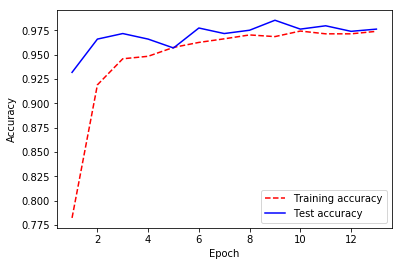

In [7]:
best_val_acc = history.history['val_acc'][-(patience+1)]
print("The best validation accuracy is:", best_val_acc)

multiheaded.save('multiheaded.h5')

%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

We have a very high accuracy of prediciton. The multiheaded network is able to look at Let's now check how confident our model when its predictions are correct and incorrect.

In [8]:
from keras.models import load_model
multiheaded = load_model('best_model.multiheaded_withz.h5')

In [9]:
pred = multiheaded.predict([x_test, x_test, x_test, x_test_ave_z])

true_predictions = []
false_predictions = []
for i in range(len(x_test)):
    guess = np.argmax(pred[i])
    true = np.argmax(y_test_onehot[i])
    guess_max = np.max(pred[i])
    if guess == true:
        true_predictions.append(guess_max)
    else:
        false_predictions.append(guess_max)
        
print("How many times is the prediction correct: ", len(true_predictions))
print("How many times is the prediction wrong: ", len(false_predictions))

How many times is the prediction correct:  858
How many times is the prediction wrong:  21


/apps/python/3.6-conda5.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 1.,
        1., 0., 1., 2., 0., 5.]),
 array([0.5585471 , 0.5684923 , 0.5784375 , 0.5883827 , 0.59832793,
        0.60827315, 0.61821836, 0.6281636 , 0.6381088 , 0.648054  ,
        0.6579992 , 0.66794443, 0.67788965, 0.68783486, 0.6977801 ,
        0.7077253 , 0.7176705 , 0.7276157 , 0.7375609 , 0.74750614,
        0.7574513 , 0.7673965 , 0.7773417 , 0.78728694, 0.79723215,
        0.80717736, 0.8171226 , 0.8270678 , 0.837013  , 0.8469582 ,
        0.85690343, 0.86684865, 0.87679386, 0.8867391 , 0.8966843 ,
        0.9066295 , 0.9165747 , 0.92651993, 0.93646514, 0.94641036,
        0.9563556 ], dtype=float32),
 <a list of 40 Patch objects>)

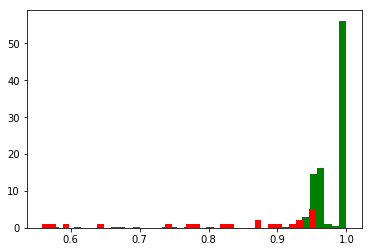

In [10]:
#Plot the probabilities when the predictions are correct(green), and when the predictions are incorrect(red)
plt.hist(true_predictions, 40, normed=True, color='g')
plt.hist(false_predictions, 40, normed=False, color='r')

As can be seen, the model is rather confident when the predictions is correct, and way less confident when the prediction is wrong. Still, there is a small chance the prediction is wrong, even when the probability is ~0.93.

Next, we will use this multiheaded network to automatically label the phases in a phase diagram generated for phase points under different D's and B's.